In [18]:
import sqlite3
import os
import polars as pl
import plot
import matplotlib.pyplot as plt
import numpy as np

## Connect + Read from Database

### Set connection parameters

In [2]:
db_dir = "/scratch/aneeshr/concurrent-quit/results/db"
db_name = "sample_db"
db_path = db_dir + "/" + db_name

In [3]:
connection = sqlite3.connect(db_path)

### Set the date/timestamp to read

In [4]:
date_to_read = "2025-04-24"

In [5]:
read_index_bench_query = f"SELECT * from index_bench where timestamp > {date_to_read};"

### Read the data

In [6]:
df = pl.read_database(
    query = read_index_bench_query, 
    connection = connection)

### Sample Read Data

In [7]:
filter_col = "index_type"
filter_predicate = "simple"

In [8]:
sample_filtered_result = df.filter(pl.col(filter_col) == filter_predicate)

In [9]:
sample_filtered_result

id,timestamp,index_type,workload_file,N,K,L,preload_time,raw_writes_time,raw_reads_time,mixed_time,updates_time,short_range_time,mid_range_time,long_range_time,size,height,internal,leaves,fast_inserts,redistribute,soft_resets,hard_resets,fast_inserts_fail,sort
i64,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
1,"""2025-04-24 17:29:26.316907+00:…","""simple""","""5_100_100""",5,100,100,2087239822,0,0,0,0,0,0,0,5000000,2,34,15293,0,0,0,0,0,0
2,"""2025-04-24 17:29:28.553915+00:…","""simple""","""5_10_100""",5,10,100,1270100003,0,0,0,0,0,0,0,5000000,2,67,18115,0,0,0,0,0,0
3,"""2025-04-24 17:29:30.931988+00:…","""simple""","""5_1_100""",5,1,100,1181074016,0,0,0,0,0,0,0,5000000,2,75,19434,0,0,0,0,0,0
4,"""2025-04-24 17:29:33.287729+00:…","""simple""","""5_25_100""",5,25,100,1393052532,0,0,0,0,0,0,0,5000000,2,56,16410,0,0,0,0,0,0
5,"""2025-04-24 17:29:35.529950+00:…","""simple""","""5_3_100""",5,3,100,1205100801,0,0,0,0,0,0,0,5000000,2,74,19091,0,0,0,0,0,0
6,"""2025-04-24 17:29:38.141628+00:…","""simple""","""5_50_100""",5,50,100,1575859515,0,0,0,0,0,0,0,5000000,2,47,14660,0,0,0,0,0,0
7,"""2025-04-24 17:29:40.565942+00:…","""simple""","""5_5_100""",5,5,100,1220262327,0,0,0,0,0,0,0,5000000,2,73,18795,0,0,0,0,0,0
8,"""2025-04-24 17:29:42.791200+00:…","""simple""","""5_0_0""",5,0,0,1035090396,0,0,0,0,0,0,0,5000000,2,76,19607,0,0,0,0,0,0


## Analysis

### Preload times

In [10]:
preload_df = df.select(
                pl.col("index_type"), 
                pl.col("K"),
                pl.col("preload_time")
)

In [20]:
# fetch index types
index_types = df["index_type"].unique().to_list()

# filter and group dfs by index types
grouped_dfs = {}
for index in index_types:
    filtered_df = preload_df.filter(pl.col("index_type") == index).sort("K")
    grouped_dfs[index] = filtered_df

k_values = sorted(preload_df["K"].unique().to_list())

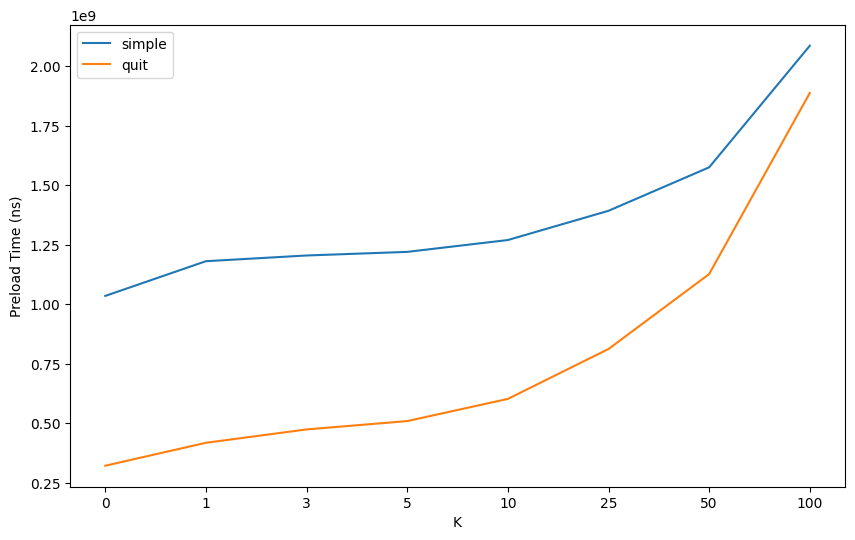

In [21]:
x_positions = np.arange(len(k_values))

plt.figure(figsize=(10,6))

for index, index_df in grouped_dfs.items():
    plt.plot(x_positions, index_df["preload_time"], label=index)

plt.xticks(x_positions, k_values)
plt.xlabel("K")
plt.ylabel("Preload Time (ns)")
plt.legend()
plt.show()